In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
orig_df = df

In [2]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[
        :, num_cols
    ] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(
        X_test[num_cols]
    )

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[
            :, std_cols
        ] = std.fit_transform(
            X_train[std_cols]
        )
        X_test.loc[
            :, std_cols
        ] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [3]:
X.shape

(1309, 8)

In [4]:
X.describe().iloc[:, [0, -1]]

,pclass,embarked_S
count,1309.000000,1309.000000
mean,-0.012831,0.698243
std,0.995822,0.459196
min,-1.551881,0.000000
25%,-0.363317,0.000000
50%,0.825248,1.000000
75%,0.825248,1.000000
max,0.825248,1.000000


In [5]:
X.iloc[[1, 4], -3:]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


In [6]:
X.loc[[677, 864], "sex_male":]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


Text(0, 0.5, 'Częstość')

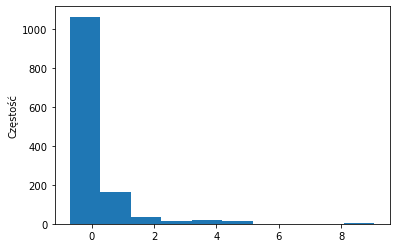

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind="hist", ax=ax)
ax.set_ylabel("Częstość")
#fig.savefig("images/mlpr_0601.png", dpi=300)

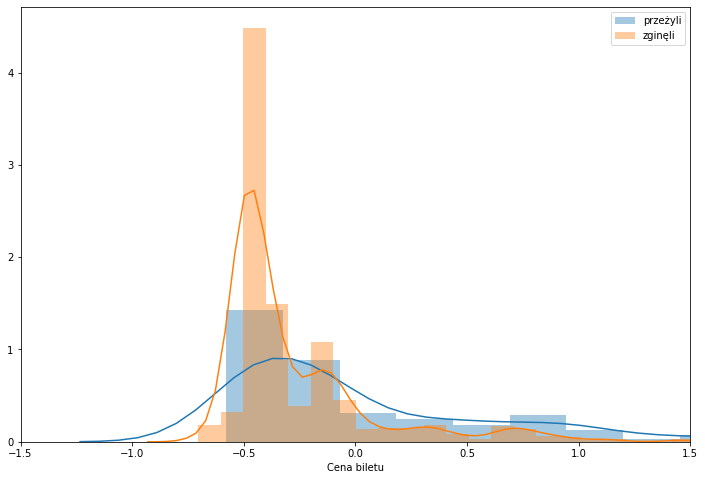

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
mask = y_train == 1
ax = sns.distplot(X_train[mask].fare, label='przeżyli')
ax = sns.distplot(X_train[~mask].fare, label='zginęli')
ax.set_xlabel("Cena biletu")
ax.set_xlim(-1.5, 1.5)
ax.legend()
#fig.savefig('images/mlpr_0602.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Cena biletu')

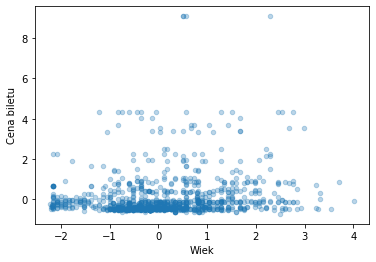

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
X.plot.scatter(
    x="age", y="fare", ax=ax, alpha=0.3
)
plt.xlabel("Wiek")
plt.ylabel("Cena biletu")
#fig.savefig("images/mlpr_0603.png", dpi=300)

In [10]:
X.age.corr(X.fare)

0.17719980495717763

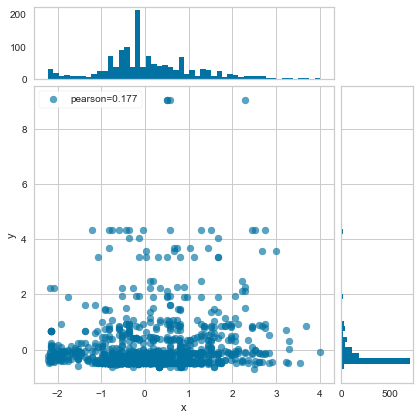

In [11]:
from yellowbrick.features import (
    JointPlotVisualizer,
)
fig, ax = plt.subplots(figsize=(6, 6))
jpv = JointPlotVisualizer(
    feature="age", target="fare"
)
jpv.fit(X["age"], X["fare"])
jpv.poof()
#fig.savefig("images/mlpr_0604.png", dpi=300)

Text(29.0, 0.5, 'Cena biletu')

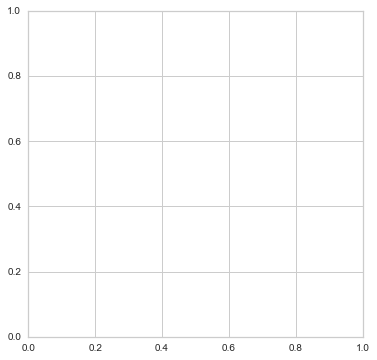

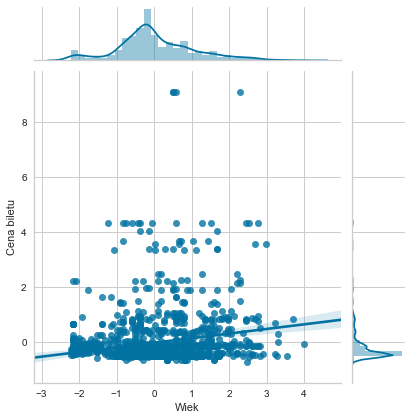

In [12]:
from seaborn import jointplot
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
p = jointplot(
    "age", "fare", data=new_df, kind="reg"
)
plt.xlabel("Wiek")
plt.ylabel("Cena biletu")
#p.savefig("images/mlpr_0605.png", dpi=300)

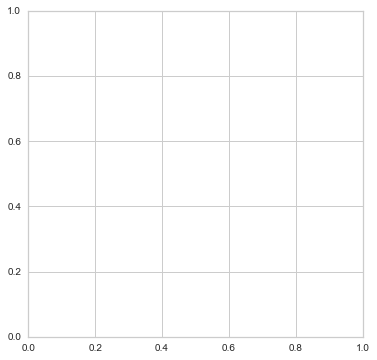

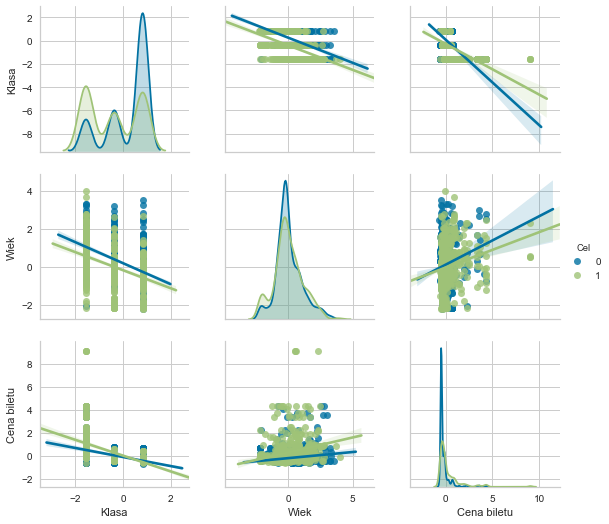

In [13]:
from seaborn import pairplot
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
vars = ["pclass", "age", "fare"]
p = pairplot(
    new_df, vars=vars, hue="target", kind="reg"
)
labels = ["Klasa", "Wiek", "Cena biletu"]
for i in range(3):
    p.axes[2][i].set_xlabel(labels[i])
    p.axes[i][0].set_ylabel(labels[i])
p._legend.remove()
p.add_legend(title="Cel")
#p.savefig("images/mlpr_0606.png", dpi=300)

Text(0, 0.5, 'Wiek')

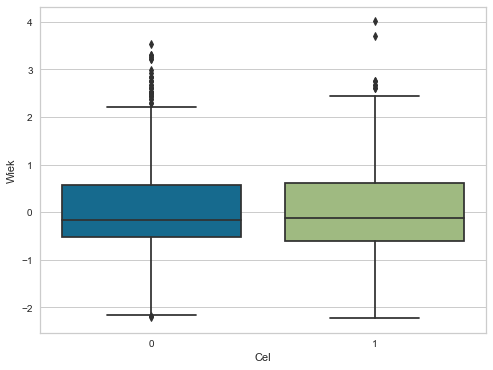

In [14]:
from seaborn import boxplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
boxplot(x="target", y="age", data=new_df)
plt.xlabel("Cel")
plt.ylabel("Wiek")
#fig.savefig("images/mlpr_0607.png", dpi=300)

Text(0, 0.5, 'Mężczyzna')

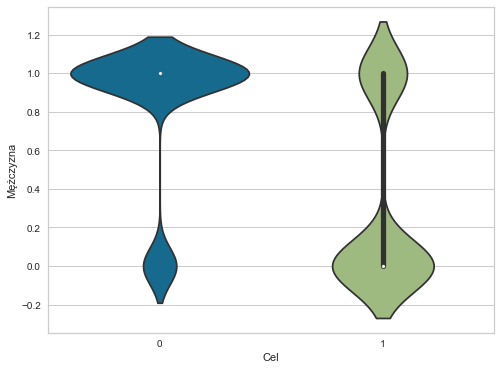

In [15]:
from seaborn import violinplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
violinplot(
    x="target", y="sex_male", data=new_df
)
plt.xlabel("Cel")
plt.ylabel("Mężczyzna")
#fig.savefig("images/mlpr_0608.png", dpi=300)

Text(0.5, 0, 'Przedział wiekowy')

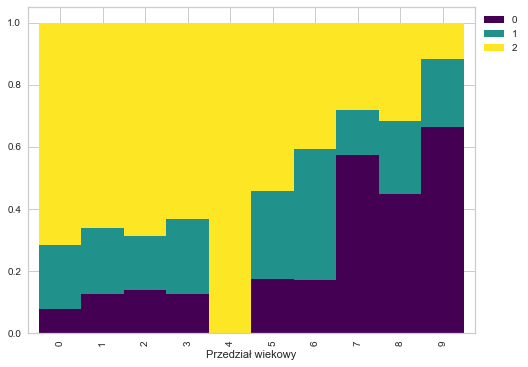

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
ax.set_xlabel("Przedział wiekowy")
#fig.savefig(
#     "image/mlpr_0609.png",
#     dpi=300,
#     bbox_inches="tight",
# )

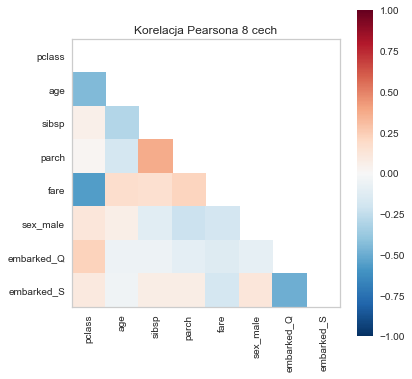

In [17]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(
    features=X.columns, algorithm="pearson", title="Korelacja Pearsona 8 cech"
)
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()
# fig.savefig(
#     "images/mlpr_0610.png",
#     dpi=300,
#     bbox_inches="tight",
#)

Text(0.5, 1, 'Korelacja 8 cech')

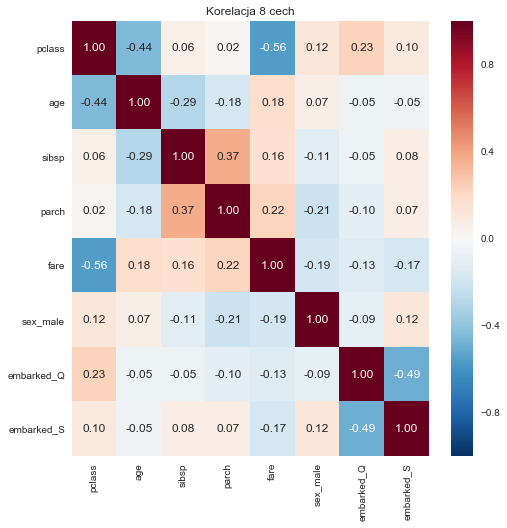

In [18]:
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax = heatmap(
    X.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
ax.set_title("Korelacja 8 cech")
# fig.savefig(
#     "images/mlpr_0611.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [19]:
X.corr().iloc[:, :2]

,pclass,age
pclass,1.000000,-0.439704
age,-0.439704,1.000000
sibsp,0.060832,-0.292056
parch,0.018322,-0.176447
fare,-0.558827,0.177200
sex_male,0.124617,0.065004
embarked_Q,0.230491,-0.053904
embarked_S,0.096335,-0.045361


In [20]:
def correlated_columns(df, threshold=0.95):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
        .stack()
        .rename("pearson")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )
correlated_columns(X)

,level_0,level_1,pearson


In [21]:
>>> agg = (
...     df.groupby("cabin")
...     .agg("min,max,mean,sum".split(","))
...     .reset_index()
... )
>>> agg.columns = [
...     "_".join(c).strip("_")
...     for c in agg.columns.values
... ]
>>> agg_df = df.merge(agg, on="cabin")

In [22]:
c_df = correlated_columns(agg_df.select_dtypes('number'))
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson
3,pclass_mean,pclass,1.00
4,pclass_mean,pclass_min,1.00
5,pclass_mean,pclass_max,1.00
6,sibsp_mean,sibsp_max,0.97
7,parch_mean,parch_min,0.95
8,parch_mean,parch_max,0.96
9,fare_mean,fare,0.95
10,fare_mean,fare_max,0.98
17,body_sum,body,1.00
18,body_sum,body_min,1.00


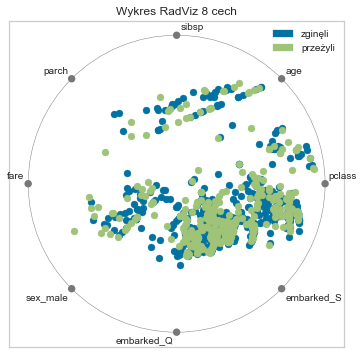

In [23]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots(figsize=(6, 6))
rv = RadViz(
    classes=["zginęli", "przeżyli"],
    features=X.columns,
    title="Wykres RadViz 8 cech"
)
rv.fit(X, y)
_ = rv.transform(X)
rv.poof()
#fig.savefig("images/mlpr_0612.png", dpi=300)

Text(0.5, 1.0, 'Wykres RadViz 8 cech')

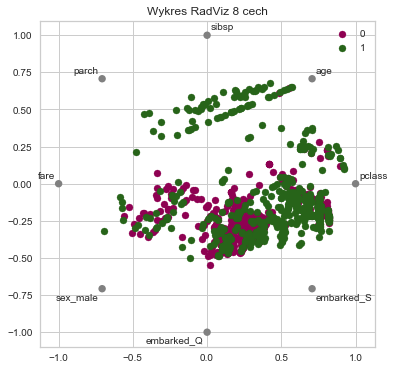

In [24]:
from pandas.plotting import radviz
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
radviz(
    new_df, "target", ax=ax, colormap="PiYG"
)
ax.set_title("Wykres RadViz 8 cech")
#fig.savefig("images/mlpr_0613.png", dpi=300)

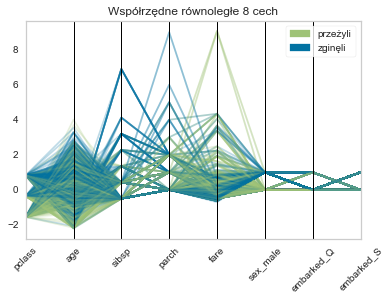

In [25]:
from yellowbrick.features import (
    ParallelCoordinates,
)
fig, ax = plt.subplots(figsize=(6, 4))
pc = ParallelCoordinates(
    classes=["zginęli", "przeżyli"],
    features=X.columns,
    title="Współrzędne równoległe 8 cech"
)
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
pc.poof()
#fig.savefig("images/mlpr_0614.png", dpi=300)

Text(0.5, 1.0, 'Współrzędne równoległe 8 cech')

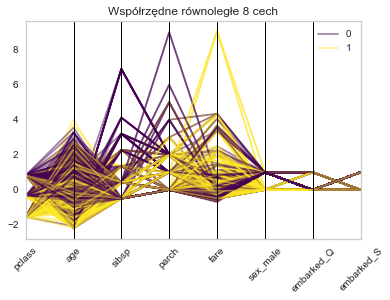

In [26]:
from pandas.plotting import (
    parallel_coordinates,
)
fig, ax = plt.subplots(figsize=(6, 4))
new_df = X.copy()
new_df["target"] = y
parallel_coordinates(
    new_df,
    "target",
    ax=ax,
    colormap="viridis",
    alpha=0.5,
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
ax.set_title("Współrzędne równoległe 8 cech")
# fig.savefig(
#     "images/mlpr_0615.png",
#     dpi=300,
#     bbox_inches="tight",
# )